In [1]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score, mean_squared_error
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 100)
%matplotlib inline

### Load and combine data
- Insert zeros as needed to match other files*** i.e. 1033 --> 01033

In [2]:
target_crop = "soybean"
repo_data_dir = "../data/"
image_dir = "../images/"
local_data_dir = '/Users/adamszabunio/Desktop/NASS_raw_data/{}/'.format(target_crop)
soy_yields = pd.read_csv(join(local_data_dir, 'soybean_historical_yields_1995_2017.csv'), index_col=0)
soy_yields2 = pd.read_csv(join(local_data_dir, 'soybean_historical_yields_1970_1994.csv'), index_col=0)
soy_yields = soy_yields.append(soy_yields2)
soy_yields.reset_index(inplace=True, drop=True)
soy_yields.fips_code = soy_yields.fips_code.astype(str).apply(lambda x: x.zfill(5))

print("Shape:", soy_yields.shape)
soy_yields.head()

Shape: (78815, 7)


fips_code state_alpha  year  nassyield county_name         asd_desc  \
0     01033          AL  2017       48.2     COLBERT  NORTHERN VALLEY   
1     01033          AL  2016       31.2     COLBERT  NORTHERN VALLEY   
2     01033          AL  2015       44.1     COLBERT  NORTHERN VALLEY   
3     01033          AL  2014       44.0     COLBERT  NORTHERN VALLEY   
4     01033          AL  2013       44.2     COLBERT  NORTHERN VALLEY   

                       location_desc  
0  ALABAMA, NORTHERN VALLEY, COLBERT  
1  ALABAMA, NORTHERN VALLEY, COLBERT  
2  ALABAMA, NORTHERN VALLEY, COLBERT  
3  ALABAMA, NORTHERN VALLEY, COLBERT  
4  ALABAMA, NORTHERN VALLEY, COLBERT

In [3]:
soy_yields.nassyield.describe()

count    78815.000000
mean        32.074361
std         10.818393
min          0.700000
25%         24.000000
50%         31.000000
75%         39.400000
max         73.100000
Name: nassyield, dtype: float64

### Exploratory Data Analysis
- Similar to the [CORN dataset](corn_EDA.ipynb), the fips code changes for "STE GENEVIEVE" County in 1986

In [4]:
s = soy_yields[soy_yields.fips_code.isin(['29193', '29186'])]
s.loc[[62047,61996]]

fips_code state_alpha  year  nassyield     county_name asd_desc  \
62047     29193          MO  1986       31.9  STE. GENEVIEVE     EAST   
61996     29186          MO  1987       36.7   STE GENEVIEVE     EAST   

                        location_desc  
62047  MISSOURI, EAST, STE. GENEVIEVE  
61996   MISSOURI, EAST, STE GENEVIEVE

In [5]:
s.groupby(["fips_code", "county_name"]).year.count()

fips_code  county_name   
29186      STE GENEVIEVE     31
29193      STE. GENEVIEVE    17
Name: year, dtype: int64

### Again, the choice is made to replace the old `fips code` with the newest
- This resolves an error when merging with county centroids 

In [6]:
soy_yields["fips_code"].replace(to_replace='29193', value='29186', inplace=True)

### No yields <= 0

In [7]:
soy_yields.nassyield.apply(lambda x: x<=0).sum()

0

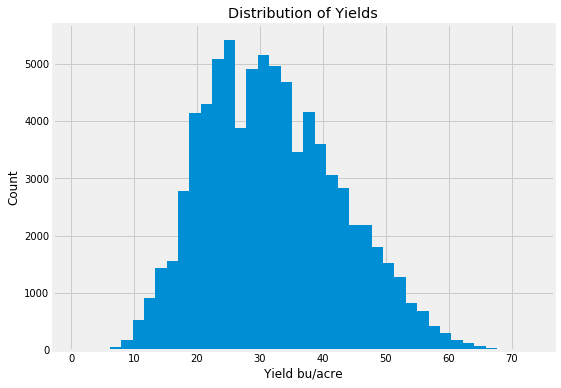

In [8]:
soy_yields.nassyield.hist(bins=40, figsize=(8,6))
plt.title("Distribution of Yields")
plt.xlabel("Yield bu/acre")
plt.ylabel("Count");

### Knowing that all yields > 0 and fips codes do not clash, where were soybeans grown?
- Where did they have Complete Data?

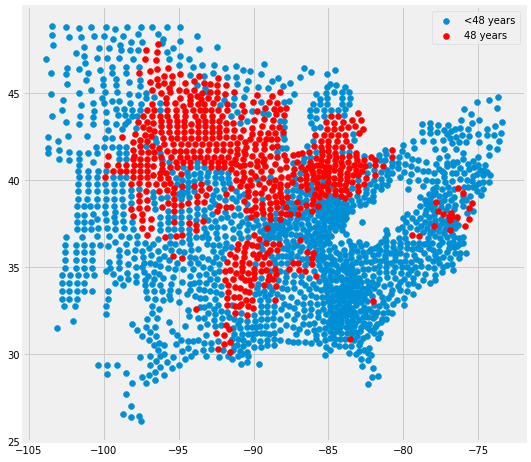

In [9]:
count_soy = soy_yields.groupby(["fips_code"])["nassyield"].count()
count_soy_df = pd.DataFrame(count_soy)
count_soy_df.columns = ["counts"]
centroids_df = pd.read_csv(join(repo_data_dir, "county_centroids.csv"), index_col=0)
centroids_df.fips_code = centroids_df.fips_code.astype(str).apply(lambda x: x.zfill(5))
centroids_df.set_index('fips_code', inplace=True)
soy_centroids = count_soy_df.join(centroids_df)
assert(soy_centroids.index.nunique() == soy_yields.fips_code.nunique())

soy_centroids48 = soy_centroids[soy_centroids["counts"] == 48]
soy_centroids_lt48 = soy_centroids[soy_centroids["counts"] != 48]
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(soy_centroids_lt48.longitude, soy_centroids_lt48.latitude, label="<48 years")
plt.scatter(soy_centroids48.longitude, soy_centroids48.latitude, c='r', label="48 years")
plt.legend();

### Pivot Dataframe Yield per County per `Year`
- Yield --> [`nassyield`]   
- County --> [`fips_code`]   

In [10]:
ts_df = soy_yields.pivot(index='fips_code', columns='year', values='nassyield')
ts_df.head()

year       1970  1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  \
fips_code                                                                     
01001      25.0  27.0  18.2  17.6  20.0  15.9  22.9  30.0  14.0  21.6  11.8   
01003      27.0  27.0  20.4  25.9  26.0  27.0  30.0  21.1  23.0  17.5  24.6   
01005      23.0  26.0  12.1  19.1  28.0  19.0  18.9  20.9  21.5  28.5  15.3   
01007      21.0  25.0  20.8  17.8  24.0  22.1  27.0  22.1  22.0  26.9  19.5   
01009      24.0  25.0  19.8  16.6  26.0  30.0  32.0  20.0  28.0  29.5  14.4   

year       1981  1982  1983  1984  1985  1986  1987  1988  1989  1990  1991  \
fips_code                                                                     
01001      19.2  22.6  19.4  24.4  23.8  22.8  15.3  24.2  15.2  12.3  17.8   
01003      25.7  26.5  30.2  26.0  24.8  25.6  25.0  27.7  22.0  19.0  25.9   
01005      20.9  27.5  19.3  18.1  26.7  18.0  18.0  25.0  22.9   NaN   NaN   
01007      24.3  25.3  17.9  22.9  22.3  19.1   NaN   NaN   NaN   NaN   NaN   
01009      25.1  30.5  15.9  18.4  29.7  26.5  19.0  25.1  27.3  16.8  25.0   

year       1992  1993  1994  1995  1996  1997  1998  1999  2000  2001  2002  \
fips_code                                                                     
01001       NaN   NaN   NaN   NaN   NaN  22.0   NaN   NaN   NaN   NaN   NaN   
01003      30.0  30.1  28.6  29.0  35.0  25.0  22.0  28.0  20.0  34.0  27.0   
01005       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
01007       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
01009      35.0  28.2  43.5  21.0  37.0  28.0  20.0  20.0  20.0  35.0  27.0   

year       2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  \
fips_code                                                                     
01001       NaN   NaN   NaN   NaN   NaN   NaN  30.0  16.9  26.0   NaN  41.2   
01003      31.0  31.0   NaN  38.0  38.0  41.5  40.5  40.0  37.0  41.0  41.9   
01005       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
01007       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
01009       NaN   NaN   NaN   NaN   NaN   NaN   NaN  24.6   NaN  41.4  49.7   

year       2014  2015  2016  2017  
fips_code                          
01001       NaN   NaN   NaN   NaN  
01003      43.8  43.4  41.8  42.0  
01005       NaN  52.1   NaN   NaN  
01007       NaN   NaN   NaN   NaN  
01009      33.9  43.8  25.0  48.6

# Notice the values are only recored to the nearest tenth
### What is the distribution of these values?

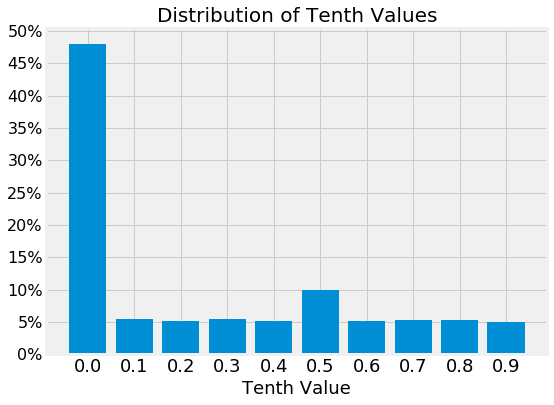

In [11]:
tenths = soy_yields.nassyield.apply(lambda x: int(str(x).split(".")[1]))
labels, counts = np.unique(tenths, return_counts=True)
percentage = counts/sum(counts) * 100

fig, ax = plt.subplots(figsize=(8,6))
plt.bar(labels, percentage, align='center')
plt.title("Distribution of Tenth Values", fontsize=20)
plt.xlabel("Tenth Value", fontsize=18)
plt.xticks(range(10), labels/10, fontsize=18)
plt.yticks(range(0,55,5), map(lambda x: x+"%", map(str, (range(0,55,5)))), fontsize=16);    

In [12]:
ts_df.describe()

year          1970         1971         1972         1973         1974  \
count  1450.000000  1446.000000  1715.000000  1752.000000  1810.000000   
mean     24.025517    25.230567    24.534111    24.653082    22.514641   
std       5.828479     5.894049     6.494447     5.224763     4.549158   
min       9.000000    10.000000     9.500000     8.000000     5.500000   
25%      20.000000    22.000000    20.000000    21.000000    19.500000   
50%      24.000000    25.000000    24.000000    24.000000    22.600000   
75%      28.000000    29.000000    29.000000    28.000000    25.500000   
max      40.000000    41.000000    42.000000    40.000000    40.000000   

year          1975         1976         1977         1978         1979  \
count  1784.000000  1781.000000  1829.000000  1848.000000  1872.000000   
mean     25.463397    23.341606    27.033461    26.040152    29.339476   
std       5.705164     6.693615     7.478861     7.032220     5.602669   
min      10.500000     5.000000    10.000000     8.000000    13.000000   
25%      21.600000    18.000000    21.000000    20.800000    25.000000   
50%      24.950000    23.000000    26.000000    25.900000    29.000000   
75%      28.700000    28.000000    33.000000    31.000000    33.000000   
max      43.000000    40.500000    44.700000    43.800000    45.000000   

year          1980         1981         1982         1983         1984  \
count  1856.000000  1822.000000  1798.000000  1856.000000  1861.000000   
mean     23.000808    27.825576    28.933593    23.650593    26.371843   
std       9.500465     7.582111     6.551290     7.628066     7.079226   
min       6.300000     8.600000    10.500000     8.400000     7.900000   
25%      14.800000    22.200000    24.500000    17.500000    21.500000   
50%      22.000000    27.000000    28.800000    22.500000    26.400000   
75%      31.000000    33.000000    33.500000    29.300000    31.100000   
max      45.800000    49.300000    45.000000    43.300000    47.300000   

year          1985         1986         1987         1988         1989  \
count  1840.000000  1802.000000  1764.000000  1799.000000  1810.000000   
mean     30.378533    29.079911    29.319785    25.704669    29.213591   
std       7.449904     8.735822     8.931632     6.209811     7.664095   
min       8.000000     1.700000     7.000000     4.000000     6.000000   
25%      25.000000    22.000000    22.000000    22.000000    24.000000   
50%      30.000000    29.500000    29.650000    25.700000    29.150000   
75%      35.800000    36.000000    36.200000    29.300000    34.900000   
max      52.500000    48.500000    50.800000    50.000000    49.000000   

year          1990         1991         1992         1993         1994  \
count  1756.000000  1721.000000  1721.000000  1658.000000  1639.000000   
mean     29.812130    31.402673    33.414178    29.660676    37.505247   
std       9.891195     8.114678     7.820376     9.409994     7.886519   
min       5.400000     3.000000     7.000000     5.000000    10.000000   
25%      21.975000    25.500000    28.000000    22.000000    32.000000   
50%      31.000000    31.000000    33.800000    30.000000    37.000000   
75%      37.900000    37.000000    39.100000    37.000000    43.000000   
max      55.700000    56.000000    53.000000    54.800000    59.000000   

year          1995         1996         1997         1998         1999  \
count  1599.000000  1609.000000  1660.000000  1660.000000  1609.000000   
mean     31.660851    34.693163    34.255542    33.049277    31.231075   
std       8.615471     7.139126     8.951279    11.024377    10.745667   
min       8.600000    12.500000    11.300000     9.200000     6.000000   
25%      25.000000    30.000000    27.875000    24.000000    22.000000   
50%      31.100000    34.700000    34.500000    33.400000    30.500000   
75%      38.100000    40.000000    41.000000    42.000000    40.000000   
max      53.500000    58.000000    57.000000    58.000000    60.000000   

In [13]:
ts_df.to_csv(join(repo_data_dir, "ts_{}_df.csv".format(target_crop)))

### Aggregates of Soybean Yields

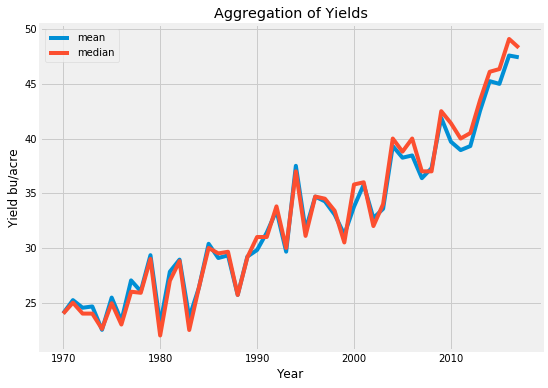

In [14]:
ts_df.agg(["mean", "median"]).T.plot(figsize=(8,6))
plt.title("Aggregation of Yields")
plt.ylabel("Yield bu/acre")
plt.xlabel("Year");

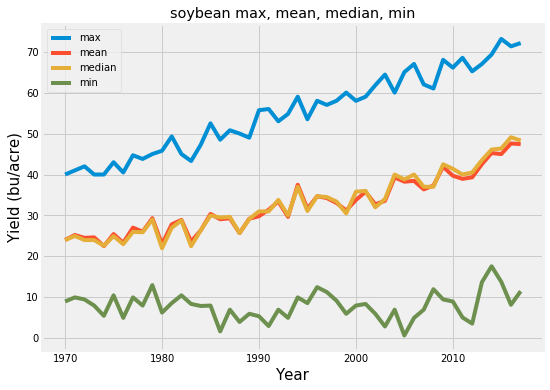

In [15]:
ts_df.agg(["max", "mean", "median", "min"]).T.plot(
    figsize=(8,6), title="{} max, mean, median, min".format(target_crop))
plt.ylabel("Yield (bu/acre)", fontsize=15)
plt.xlabel("Year", fontsize=15);

In [16]:
ts_df.min().sort_values()[:5]

year
2005    0.7
1986    1.7
2003    2.9
1991    3.0
2012    3.6
dtype: float64

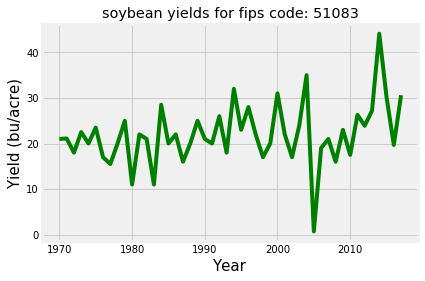

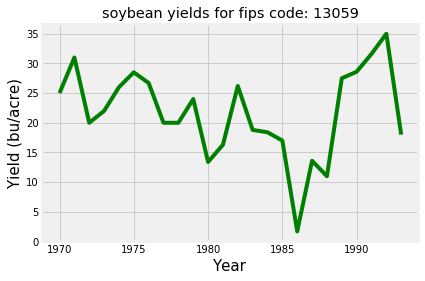

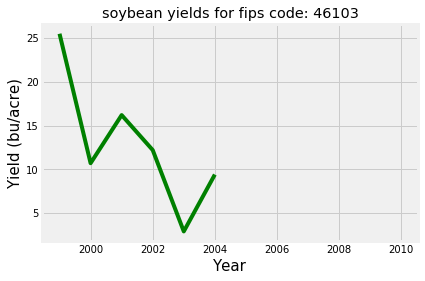

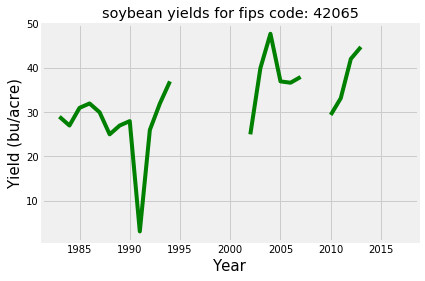

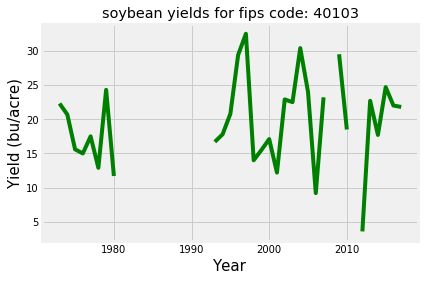

In [17]:
fips_to_check = []
for val in ts_df.min().sort_values()[:5]:
    low_fip = soy_yields[soy_yields.nassyield == val].fips_code.values[0]
    fips_to_check.append(low_fip)


for fip in fips_to_check:
    ts_df.xs(fip).plot(title="{} yields for fips code: {}".format(
        target_crop, fip), color='g')
    plt.ylabel("Yield (bu/acre)", fontsize=15)
    plt.xlabel("Year", fontsize=15);
    plt.show();

### % of `Counties` per `Year` where Soybean `Yield` was below 10, 20, & 30 bushels/acre

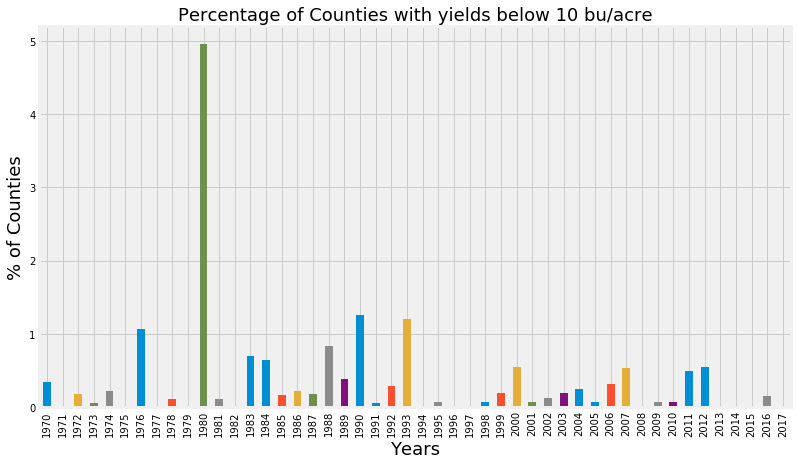

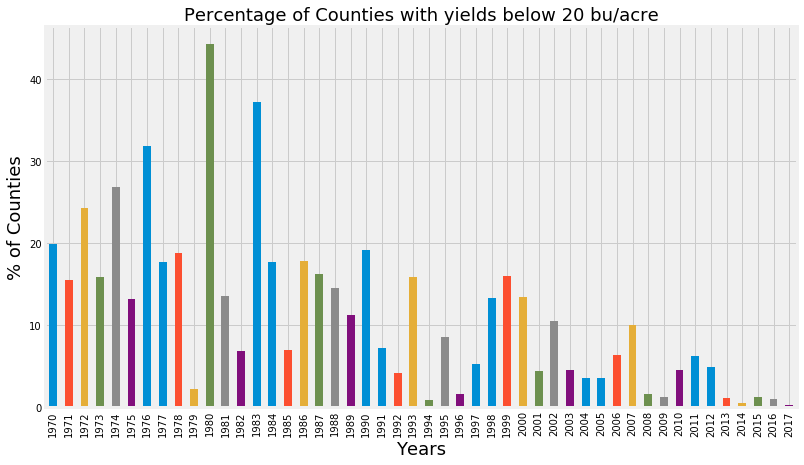

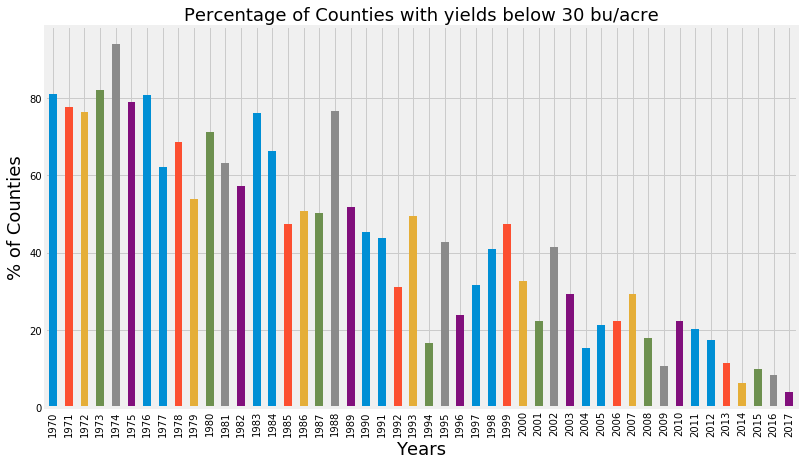

In [18]:
for i in range(10, 31, 10):
    lessthan_df = (ts_df.applymap(lambda x: x<i).sum().divide(ts_df.count()) * 100)
    lessthan_df.plot(kind='bar', figsize=(12,7))
    plt.xlabel("Years", fontsize=18)
    plt.ylabel("% of Counties", fontsize=18)
    plt.title("Percentage of Counties with yields below {} bu/acre".format(i), fontsize=18)
    plt.show();

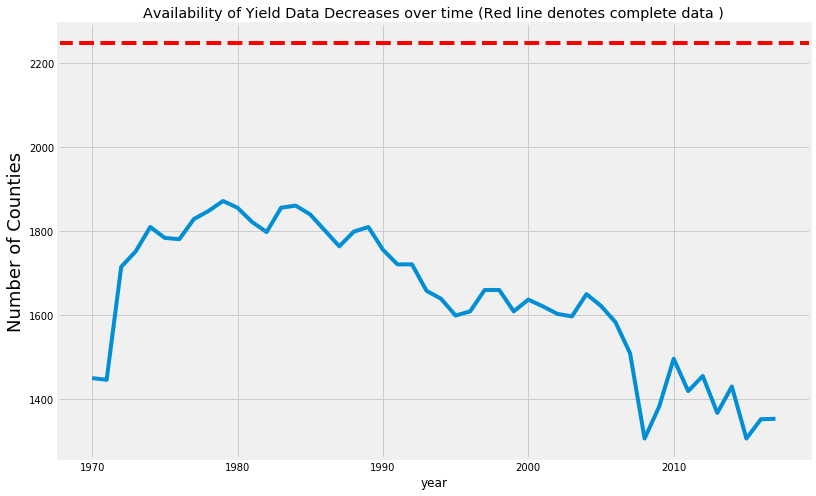

In [19]:
# save variables to be used throughout notebook
counties, years = ts_df.shape

fig, ax = plt.subplots(figsize=(12,8))
plt.axhline(y=counties, color='r', linestyle='--')
plt.title("Availability of Yield Data Decreases over time (Red line denotes complete data )")
ts_df.count().plot()
# plt.title("Number of Counties w/ Yield Data Avaialble Decreases over Time")
plt.ylabel("Number of Counties", fontsize=18);

### Nearly 70% of counties have at least 30 years (consecutive years not a requirement)

In [20]:
a = pd.DataFrame({"year_count":ts_df.T.count()})

a[a.year_count>=30].count()[0]/a.shape[0]*100

69.70640569395017

### 28.6% of Soybean data is Complete

In [21]:
complete_data = ts_df.T.count().value_counts()[years]
percent_complete = round(complete_data/counties *100, 2)
complete_data, counties, percent_complete

(643, 2248, 28.6)

### Save Full Data for Training

In [22]:
full_data = ts_df[ts_df.index.isin(a[a.year_count==years].index.values)]
full_data.head()

year       1970  1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  \
fips_code                                                                     
01049      23.0  27.0  22.2  18.6  21.0  23.0  23.0  20.0  24.0  29.3  14.0   
01077      22.0  29.0  24.4  19.7  20.0  26.5  22.0  18.0  17.9  24.5  14.0   
01083      22.0  29.0  22.5  24.0  22.0  30.0  26.0  19.9  21.0  27.2  17.9   
01089      21.0  24.0  19.7  18.3  20.0  24.0  22.0  21.0  22.0  26.3  14.0   
05001      26.0  29.0  25.0  29.0  27.0  31.0  27.2  27.6  28.0  31.0  19.0   

year       1981  1982  1983  1984  1985  1986  1987  1988  1989  1990  1991  \
fips_code                                                                     
01049      23.9  23.4  17.1  22.5  29.0  18.0  17.0  25.0  26.8  21.9  22.0   
01077      22.8  27.6  18.6  15.7  32.2  21.8  16.5  17.7  21.0  13.6  25.0   
01083      25.5  29.2  15.5  21.0  32.5  25.0  13.0  23.1  23.2  15.7  26.5   
01089      23.3  28.3  14.7  22.5  29.8  29.0  17.0  24.2  22.3  22.0  28.2   
05001      30.0  29.0  26.0  28.0  30.0  30.0  30.0  32.0  28.0  33.0  34.1   

year       1992  1993  1994  1995  1996  1997  1998  1999  2000  2001  2002  \
fips_code                                                                     
01049      32.8  24.7  37.1  25.0  36.0  26.0  20.0  15.0  25.0  38.0  19.0   
01077      30.5  23.9  27.2  27.0  36.0  27.0  27.0   6.0   9.0  38.0  25.0   
01083      29.9  28.2  32.6  24.0  36.0  30.0  22.0   8.0  17.0  35.0  25.0   
01089      31.0  25.6  36.3  24.0  37.0  27.0  22.0  12.0  20.0  34.0  23.0   
05001      35.0  32.2  38.6  33.0  37.0  38.7  30.4  41.0  35.0  40.0  42.0   

year       2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  \
fips_code                                                                     
01049      39.0  39.0  40.0  20.0  17.0  25.5  38.0  23.3  30.0  47.0  47.9   
01077      37.0  31.0  28.0  24.0  18.0  26.5  39.5  24.5  31.0  46.4  40.1   
01083      39.0  40.0  31.0  16.0  18.0  34.0  44.5  26.0  38.0  48.4  45.0   
01089      36.0  35.0  31.0  16.0  21.0  38.5  42.0  22.6  34.5  46.3  43.6   
05001      45.0  46.0  41.0  46.0  46.0  42.0  45.0  43.2  44.3  50.7  51.8   

year       2014  2015  2016  2017  
fips_code                          
01049      44.3  45.6  29.2  46.1  
01077      37.5  46.5  29.9  46.3  
01083      37.8  47.4  31.8  50.3  
01089      42.7  45.8  37.6  42.4  
05001      55.1  53.9  54.4  53.7

In [23]:
full_data.to_csv(join(repo_data_dir, "ts_{}_{}yr_df.csv".format(target_crop, years)))

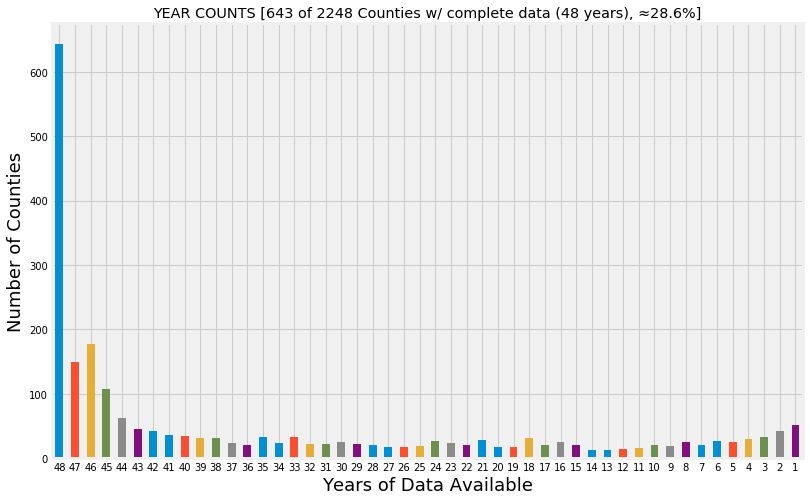

In [24]:
fig, ax= plt.subplots(figsize=(12, 8))
reverse_count = ts_df.T.count().value_counts().sort_index(ascending=False)

reverse_count.plot(kind="bar", rot=0)
plt.title("YEAR COUNTS [{} of {} Counties w/ complete data ({} years), ≈{}%]".format(
                                complete_data, counties, years, percent_complete))
plt.ylabel("Number of Counties", fontsize=18)
plt.xlabel("Years of Data Available", fontsize=18);
fig.savefig(join(image_dir, "{}_year_counts".format(target_crop)))

#  TODO: Plots 
### Corn and Soybean together
- Year Counts (as percentage)
- Cumulative Sums
- Num counties per state

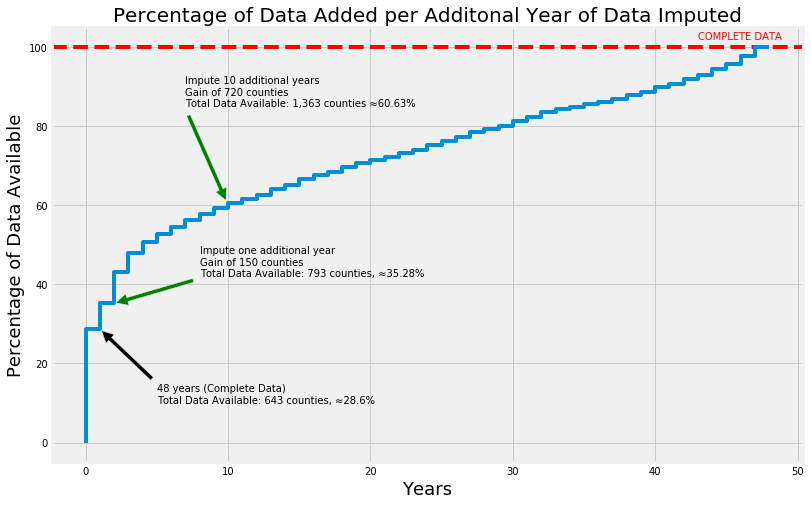

In [25]:
def commas(val):
    return "{:,}".format(val)

cumulative_sum = reverse_count.cumsum()
cumulative_percent = (cumulative_sum/counties).values.tolist()
cumulative_percent.insert(0,0)
cumulative_percent = np.array(cumulative_percent) * 100

fig, ax = plt.subplots(figsize=(12,8))
plt.axhline(y=100, color='r', linestyle='--')
plt.annotate("COMPLETE DATA", xy=(49, 100), xytext=(43, 102), color="r")
plt.title("Percentage of Data Added per Additonal Year of Data Imputed", fontsize=20)
plt.xlabel("Years", fontsize=18)
plt.ylabel("Percentage of Data Available", fontsize=18) 
plt.annotate('{} years (Complete Data) \nTotal Data Available: {} counties, ≈{}%'.format(
             years, complete_data, percent_complete),
             xy=(.9, 29), xytext=(5, 10),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("""
Impute one additional year 
Gain of {} counties 
Total Data Available: {} counties, ≈{:.2f}%""".format(
    reverse_count[years-1], cumulative_sum[years-1],
    cumulative_sum[years-1]/counties *100),
    xy=(1.8, 35), xytext=(8, 42), 
    arrowprops=dict(facecolor='green', shrink=0.05)
)
plt.annotate("""
Impute 10 additional years 
Gain of {} counties 
Total Data Available: {} counties ≈{:.2f}%""".format(
    cumulative_sum[years-10] - cumulative_sum[years], 
    commas(cumulative_sum[years-10]),
    cumulative_sum[years-10]/counties *100), 
    xy=(10, 60), xytext=(7, 85), 
    arrowprops=dict(facecolor='green', shrink=0.05))
plt.step(np.arange(0, years+1), cumulative_percent);
fig.savefig(join(image_dir, "{}_cumulative_sum".format(target_crop)))

### States w/ Complete Data

In [26]:
complete_states = soy_yields[soy_yields.fips_code.isin(a[a.year_count==years].index.values)]

complete_states['state_alpha'].unique()

array(['AL', 'AR', 'DE', 'GA', 'IL', 'IN', 'IA', 'KS', 'LA', 'MD', 'MI',
       'MN', 'MS', 'MO', 'NE', 'ND', 'OH', 'OK', 'SD', 'TN', 'VA', 'WI'],
      dtype=object)

### Intersection and Differences for Corn and Soybean States

In [27]:
corn_states = set(
    ['AL', 'AR', 'CA', 'CO', 'DE', 'GA', 'IL', 'IN', 'IA', 'KS', 'KY',
    'LA', 'MD', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NJ', 'NC', 'ND',
    'OH', 'PA', 'SC', 'SD', 'TN', 'TX', 'VA', 'WV', 'WI', 'WY'])

soy_states = set(complete_states['state_alpha'])

len(corn_states), len(soy_states), len(corn_states.intersection(soy_states))

(32, 22, 21)

In [28]:
soy_states.difference(corn_states)

{'OK'}

In [29]:
corn_states.difference(soy_states)

{'CA', 'CO', 'KY', 'MT', 'NC', 'NJ', 'PA', 'SC', 'TX', 'WV', 'WY'}

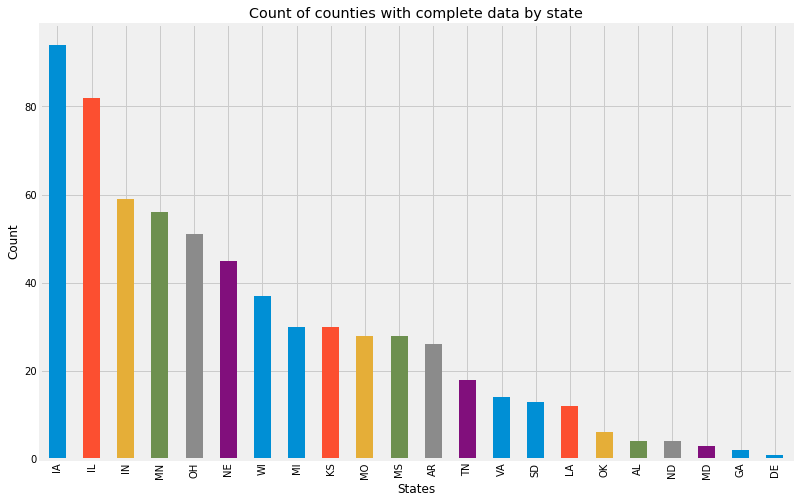

In [30]:
complete_states_count = complete_states['state_alpha'].value_counts()/years
ax = complete_states_count.plot(kind='bar', figsize=(12,8), 
                               title="Count of counties with complete data by state")
ax.set(xlabel='States', ylabel='Count');

 ______

# Missing Data

### How's Iowa looking?

In [31]:
iowa_df = soy_yields[soy_yields.state_alpha == "IA"].pivot(
    index='fips_code', columns='year', values='nassyield')

"{} Unique Iowa counties".format(iowa_df.index.nunique())

'99 Unique Iowa counties'

In [32]:
iowa_null_df = iowa_df.isnull().sum()[iowa_df.isnull().sum()>0]
iowa_null_years = iowa_null_df.index
iowa_null_df

year
2015    2
2017    3
dtype: int64

In [33]:
iowa_df.loc[iowa_df.isnull().any(axis=1)][iowa_null_years]

year       2015  2017
fips_code            
19039      41.3   NaN
19053      46.4   NaN
19129       NaN  55.2
19173       NaN  52.4
19185      45.0   NaN

# Testing out `cmaps` & `"bad" colors`

In [34]:
plt.style.use("seaborn")

magma


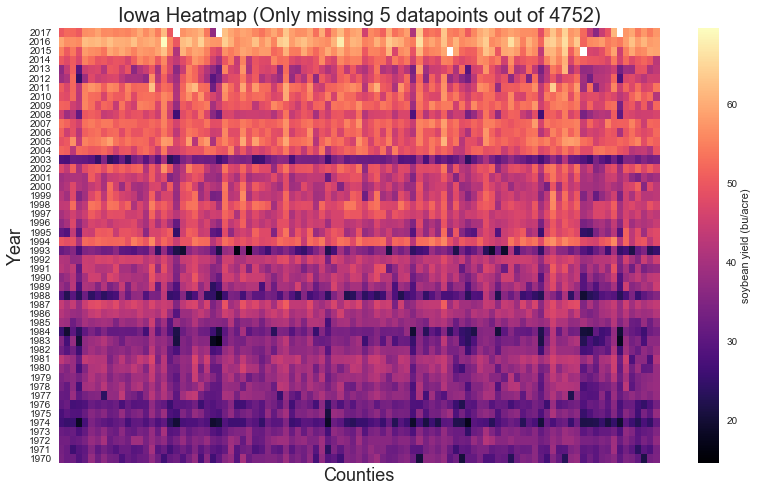

inferno


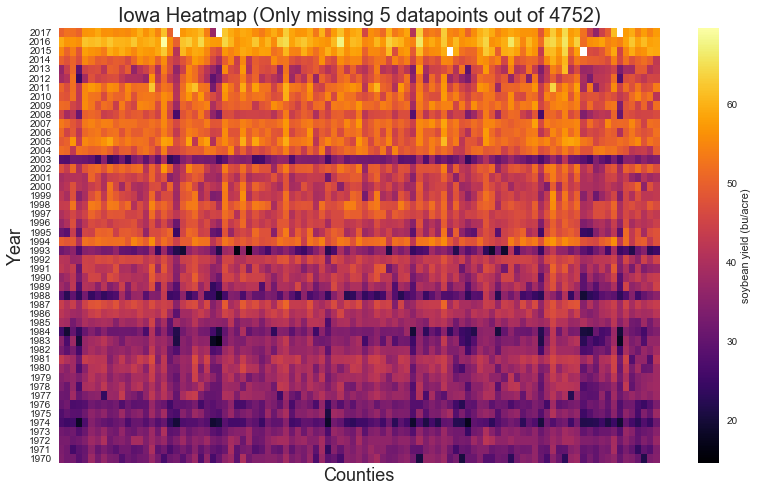

plasma


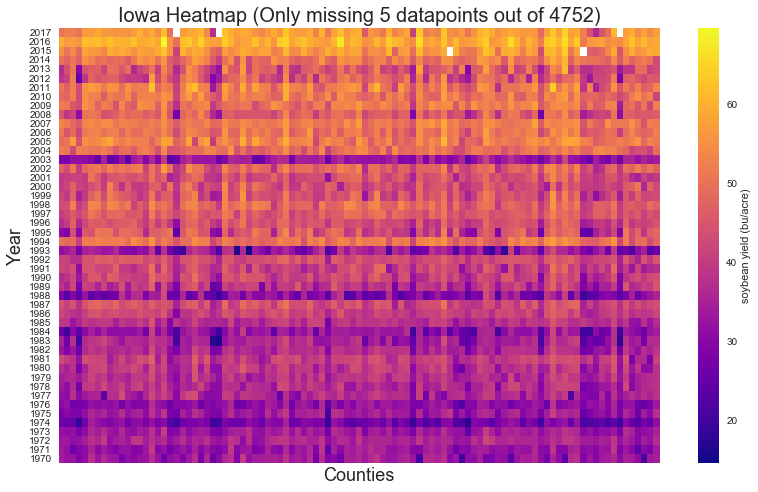

viridis


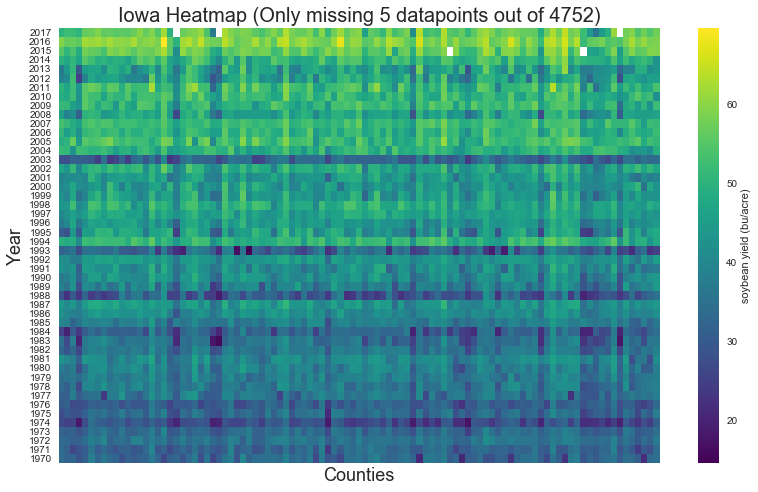

In [35]:
for c in ["magma","inferno", "plasma", "viridis"]:
    print(c)
    fig, ax = plt.subplots(figsize=(12,8))
    cmap = plt.get_cmap(c)
    cmap.set_bad(color = 'w', alpha = 1.)
    sns.heatmap(iowa_df.T, yticklabels=1, xticklabels=False, cmap=cmap,
                cbar_kws={'label': '{} yield (bu/acre)'.format(target_crop)})
    ax.set_title("Iowa Heatmap (Only missing {} datapoints out of {})".format(
    iowa_null_df.sum(), iowa_df.size), fontsize=20)
    ax.invert_yaxis()
    ax.set_ylabel("Year", fontsize=18)
    ax.set_xlabel("Counties", fontsize=18)
    plt.show();

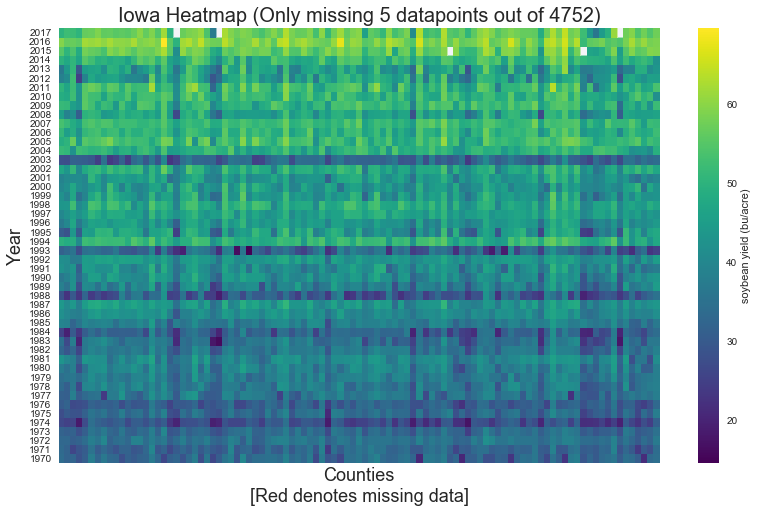

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
cmap = plt.get_cmap('viridis')
cmap.set_bad(color = 'w', alpha = 0.5)
sns.heatmap(iowa_df.T, yticklabels=1, xticklabels=False, cmap=cmap,
            cbar_kws={'label': '{} yield (bu/acre)'.format(target_crop)})
ax.set_title("Iowa Heatmap (Only missing {} datapoints out of {})".format(
iowa_null_df.sum(), iowa_df.size), fontsize=20)
ax.invert_yaxis()
ax.set_ylabel("Year", fontsize=18)
ax.set_xlabel("Counties\n[Red denotes missing data]", fontsize=18);
# fig.savefig(join(image_dir, "IA_{}_heatmap".format(target_crop)))

In [37]:
def state_heatmap(state, state_name, df, miss_color='White', crop=target_crop, 
                  save_dir=image_dir, save_fig=True):
    if isinstance(state, str):
        state_df = df[df.state_alpha == state].pivot(index='fips_code', 
                                                     columns='year', values='nassyield')
    elif isinstance(state, list):
        state_df = df[df.state_alpha.isin(state)].pivot(index='fips_code', 
                                                     columns='year', values='nassyield')
        
    else:
        return("""State must be either a single state abbreviation of type str 
                  or a list of state abbreviation of type str""")
    state_null_df = state_df.isnull().sum()[state_df.isnull().sum()>0]
    miss, total = state_null_df.sum(), state_df.size
    percent = commas(round(miss/total *100, 2))
    
    fig, ax = plt.subplots(figsize=(12,8))
    cmap = plt.get_cmap('viridis')
    cmap.set_bad(color=miss_color, alpha = 0.5)
    sns.heatmap(state_df.T, yticklabels=1, xticklabels=False, cmap=cmap)
    ax.set_title("{} Heatmap (Missing {} datapoints out of {}. ≈{}%)".format(
        state_name, commas(miss), commas(total), percent), fontsize=18)
    ax.invert_yaxis()
    ax.set_xlabel("{} Counties\n[{} denotes missing data]".format(
        commas(state_df.shape[0]), miss_color), fontsize=18)
    ax.set_ylabel("Year", fontsize=20)
    ax.figure.axes[-1].set_ylabel('{} yield (bu/acre)'.format(crop), size=18)
    if save_fig:
        fig.savefig(join(save_dir, "{}_{}_heatmap".format(state_name, crop)))

# Heatmap for Iowa

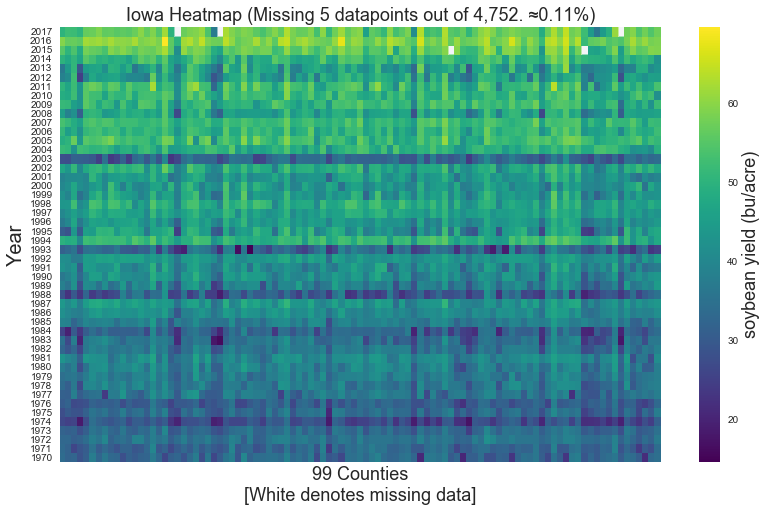

In [38]:
state_heatmap("IA", "Iowa", soy_yields)

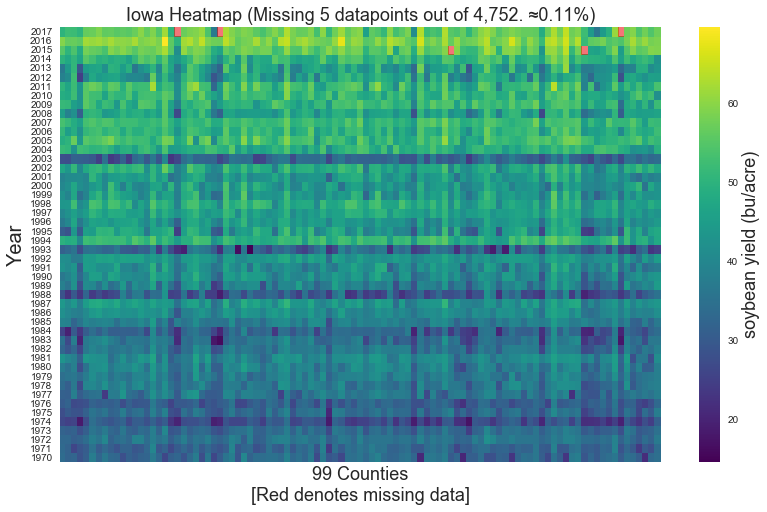

In [39]:
state_heatmap("IA", "Iowa", soy_yields, miss_color='Red')

# Heatmap for Alabama

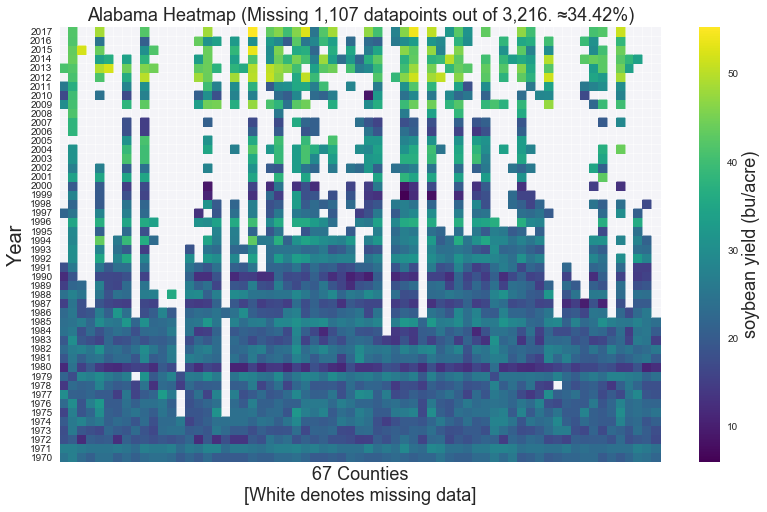

In [40]:
state_heatmap("AL", "Alabama", soy_yields)

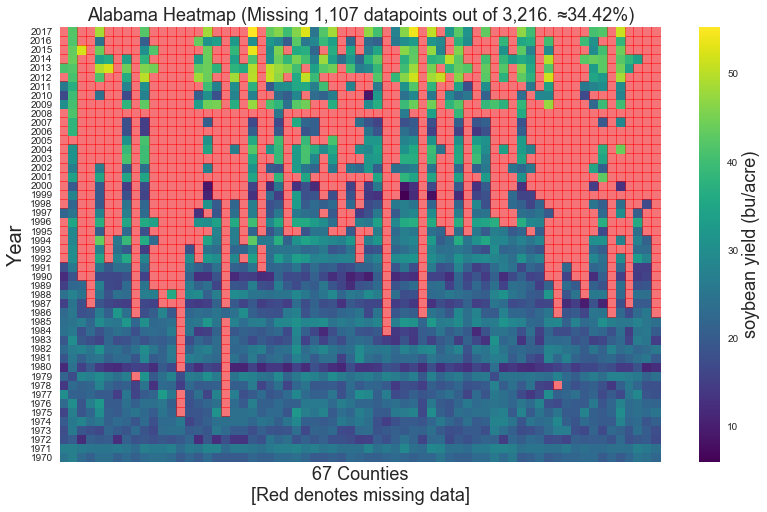

In [41]:
state_heatmap("AL", "Alabama", soy_yields, miss_color="Red", save_fig=False)

# Heatmap for Oklahoma

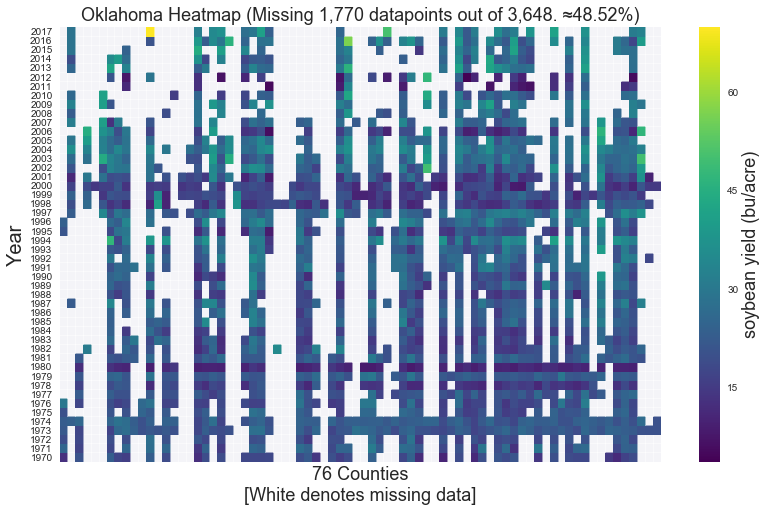

In [42]:
state_heatmap("OK", "Oklahoma", soy_yields)

# Heatmap of All Soybean Data

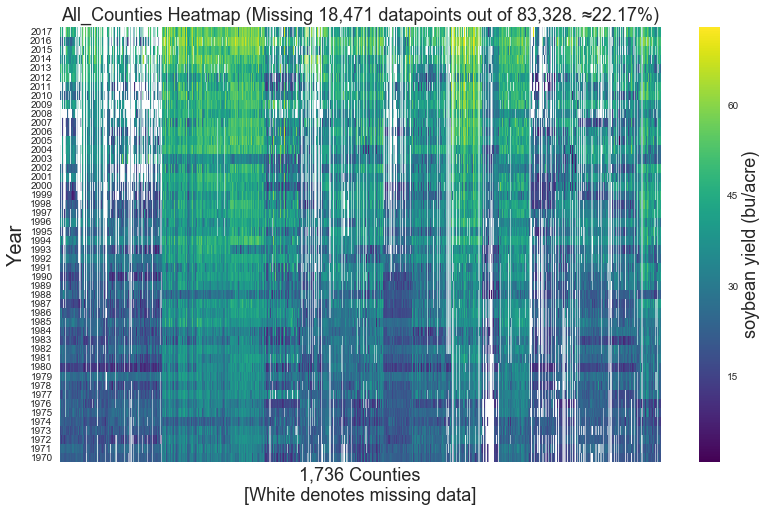

In [43]:
state_heatmap(list(soy_states), "All_Counties", soy_yields)

___